# Examining Racial Discrimination in the US Job Market

### Background
Racial discrimination continues to be pervasive in cultures throughout the world. Researchers examined the level of racial discrimination in the United States labor market by randomly assigning identical résumés to black-sounding or white-sounding names and observing the impact on requests for interviews from employers.

### Data
In the dataset provided, each row represents a resume. The 'race' column has two values, 'b' and 'w', indicating black-sounding and white-sounding. The column 'call' has two values, 1 and 0, indicating whether the resume received a call from employers or not.

Note that the 'b' and 'w' values in race are assigned randomly to the resumes when presented to the employer.

In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as ss
import seaborn as sns

from IPython.display import Image
from scipy import stats

In [2]:
data = pd.io.stata.read_stata('data/us_job_market_discrimination.dta')

In [3]:
data.head()

,id,ad,education,ofjobs,yearsexp,honors,volunteer,military,empholes,occupspecific,...,compreq,orgreq,manuf,transcom,bankreal,trade,busservice,othservice,missind,ownership
0,b,1,4,2,6,0,0,0,1,17,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
1,b,1,3,3,6,0,1,1,0,316,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
2,b,1,4,1,6,0,0,0,0,19,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
3,b,1,3,4,6,0,1,0,1,313,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,
4,b,1,3,3,22,0,0,0,0,313,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Nonprofit


In [4]:
# number of callbacks for black-sounding names
sum(data[data.race =='b'].call)

157.0

In [5]:
# number of callbacks for white-sounding names
sum(data[data.race == 'w'].call)

235.0

In [6]:
# create a function that creates a dataframe with the data we want which is the call and callback information for the given group
def create_df(df,column_name):
    test_df = df[[column_name,'call']]
    new_df = test_df.groupby(column_name).sum() #get the sum of 1's in the call column by group
    new_df['nocall'] = test_df.groupby(column_name).size() - new_df.call # get the sum of 0's in the call column by group
    new_df['total'] = new_df.call + new_df.nocall # get the total number of resumes in each group
    new_df['prob'] = (new_df.call/new_df.total) # get the percentage of call backs for each group
    new_df = new_df.sort_values('prob') # sort for plotting later
    return new_df

In [7]:
create_df(data,'race')

,call,nocall,total,prob
race,,,,
b,157.0,2278.0,2435.0,0.064476
w,235.0,2200.0,2435.0,0.096509


# Answers to Questions

##  What test is appropriate for this problem? Does CLT apply?

Since the data represents discrete random variables, the distribution will be a Bernoulli distribution.  We will want to use large sample proportion hypothesis testing.  The Central Limit Theorem still applies. For large sample sizes of n, the distribution of the count of 1's and the sample proportion (count/n) are approximately normal.

## What are the null and alternate hypotheses?

The null hypothesis is that having the black sounding name will have no effect on the callback rate and that the probability of a call back for a black sounding name will be the same as the probability of a call back for the white sounding name.  The alternate hypothesis is that the black sounding name will have an effect on the callback rate.  **Null:  no effect.  Alternate:   there is an effect.**

## Compute margin of error, confidence interval, and p-value.

The null hypothesis is that having a black sounding name has no effect on the probability of a callback for a black sounding name is the same as that for the applicants with white sounding names.  Null:  P(black) = P(white) The alternative hypothesis is that P(white) > P(black).

In [8]:
# create a function that calculates p_value, margin_of_error, and confidence_interval for proportion hypothesis testing

def get_prop_stats(df, prob_column, total_column):

# Grab the probability and n values from the df    
    prob1, n1 = df.ix[0, prob_column], df.ix[0, total_column]
    prob2, n2 = df.ix[1, prob_column], df.ix[1, total_column]    

# Let's find the std deviation of prob_white - prob_black
    std_dev = (prob1*(1.0 - prob1)/n1 + prob2*(1.0 - prob2)/n2)**0.5

# find critical point, critical_value, where a value above this would occur less than 5% of the time (95% confidence level)
    critical_value = 1.96 * std_dev

# calculate the difference in the probabilities
    prob_diff = abs(prob1 - prob2)

# calculate the z-statistic
    z = (prob_diff - 0.0)/std_dev

# calculate the p-value
    p_value = 1 - ss.norm.cdf(z)

#Calculate the margin or error and confidence interval
    margin_of_error = critical_value

    confidence_interval = (prob_diff - margin_of_error,
                       prob_diff + margin_of_error) 
    print('p_value:',p_value)
    print('margin of error:', margin_of_error)
    print('confidence interval:', confidence_interval)
    return p_value, margin_of_error, confidence_interval

In [9]:
race_df = create_df(data,'race')
get_prop_stats(race_df, 'prob', 'total');

('p_value:', 1.9312826037620745e-05)
('margin of error:', 0.015255406349886438)
('confidence interval:', (0.016777447859559147, 0.047288260559332024))


** The p-value is low so we reject the null hypothesis that the probability of a callback for the "black" group is the same as the "white" group and adopt the alternate hypothesis that the probability of a callback for the "white" group is higher than the probabililty of a callback for the "black" group.**

In [10]:
# what is the difference between the percentage of callbacks for the "black" group versus the "white" group
prob_black = race_df.ix['b','prob']
prob_white = race_df.ix['w','prob']
prob_delta = (prob_white - prob_black)*100
prob_delta

3.2032854209445585

With a 95% confidence level, we can say that the probability of there being a difference of 3.2% in callbacks between the white and black groups is between 1.67% and 4.73%.  This is less than 5% so we reject the null hypothesis of the callback proportions being equal and adopt the alternative hypothesis which is that the proportion of white call backs is greater than the proportion of black callbacks.

# Create Plots for a Data Story

In [11]:
# create a row called g to represent the entire group so we can compare the general number of callbacks to the group callbacks
race_df.ix['g'] = race_df.sum(axis=0)

In [12]:
race_df

,call,nocall,total,prob
race,,,,
b,157.0,2278.0,2435.0,0.064476
w,235.0,2200.0,2435.0,0.096509
g,392.0,4478.0,4870.0,0.160986


We observe that the probability of receiving a callback in general is 16.1%.  The probability of receiving a callback in the white group is 9.7% and the probability of receiving a callback in the black group is 6.4%.

In [13]:
# create a set of labels for the bar plot
race_df['labels'] = ['Black','White','Both']

In [14]:
race_df

,call,nocall,total,prob,labels
race,,,,,
b,157.0,2278.0,2435.0,0.064476,Black
w,235.0,2200.0,2435.0,0.096509,White
g,392.0,4478.0,4870.0,0.160986,Both


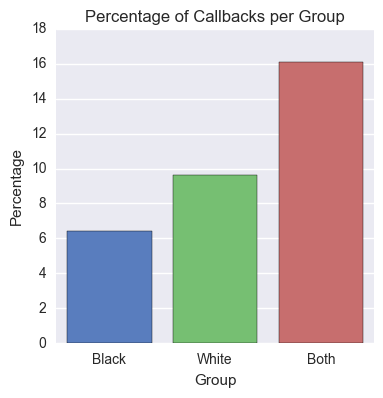

In [15]:
race_df['prob'] = race_df.prob*100
sns.factorplot(x='labels', y='prob', data = race_df, kind="bar", palette="muted", size=4, aspect=1)
plt.title('Percentage of Callbacks per Group')
plt.xlabel('Group')
plt.ylabel('Percentage')
plt.savefig('percent_callbacks_race')

** The "white" group received approximately 3.3% more callbacks than the "black" group. The overall callback rate was 16.1%.**

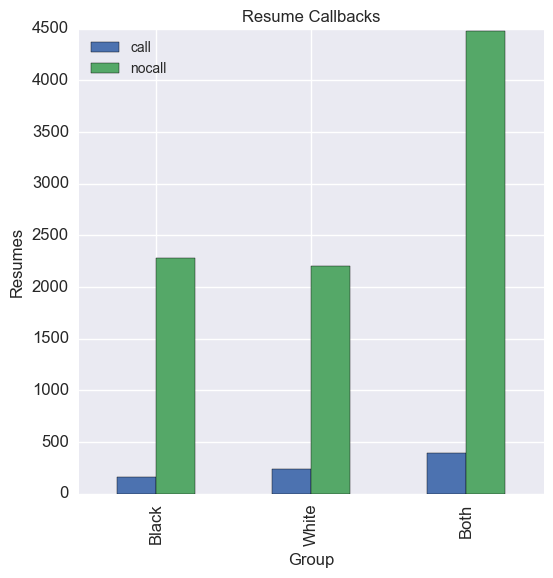

In [16]:
# create a plot of the raw number of callbacks per group compared to the total number of resumes submitted
race_df = race_df.set_index('labels')
ax = race_df[['call','nocall']].plot(kind='bar', title ="Resume Callbacks", figsize=(6, 6), legend=True, fontsize=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Resumes", fontsize=12)
plt.show()
plt.savefig('num_callbacks_race')

** The number of callbacks, in general, is low.**

** Let's investigate whether the same "bias" occurs for email responses.**

In [17]:
#create a function for creating a dataframe with information for email responses 
def create_df_email(df,column_name):
    test_df = df[[column_name,'email']]
    new_df = test_df.groupby(column_name).sum() #get the sum of 1's in the email column by group
    new_df['no_email'] = test_df.groupby(column_name).size() - new_df.email # get the sum of 0's in the email column by group
    new_df['email_total'] = new_df.email + new_df.no_email # get the total number of resumes in each group
    new_df['email_prob'] = (new_df.email/new_df.email_total) # get the percentage of email responses for each group
    new_df = new_df.sort_values('email_prob') # sort for plotting later
    return new_df

In [18]:
race_email_df = create_df_email(data,'race')
race_email_df.ix['g'] = race_email_df.sum(axis=0)
race_email_df['labels'] = ['White','Black','Both']

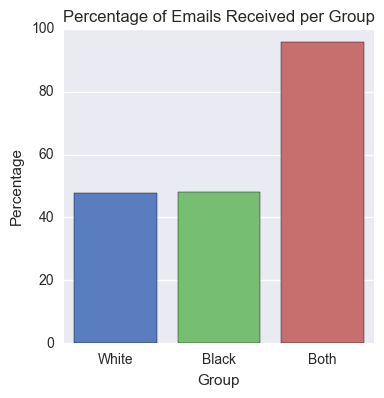

In [19]:

race_email_df['email_prob'] = race_email_df.email_prob*100
sns.factorplot(x='labels', y='email_prob', data = race_email_df, kind="bar", palette="muted", size=4, aspect=1)
plt.title('Percentage of Emails Received per Group')
plt.xlabel('Group')
plt.ylabel('Percentage')
plt.savefig('percent_emails_race')

** The percentage of email responses that were received by the "black" group was equal to that of the "white" group.**

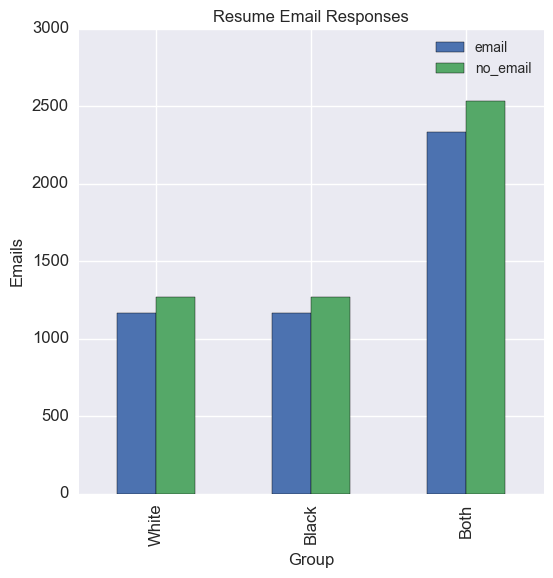

In [20]:

race_email_df = race_email_df.set_index('labels')
ax = race_email_df[['email','no_email']].plot(kind='bar', title ="Resume Email Responses", figsize=(6, 6), legend=True, fontsize=12)
ax.set_xlabel("Group", fontsize=12)
ax.set_ylabel("Emails", fontsize=12)
plt.show()
plt.savefig('num_emails_race')

** The email response to resumes is much higher than a callback.  The email response is 48% for both groups.**

In [21]:
race_email_df

,email,no_email,email_total,email_prob
labels,,,,
White,1166.0,1269.0,2435.0,47.885010
Black,1168.0,1267.0,2435.0,47.967146
Both,2334.0,2536.0,4870.0,95.852156


How many of the resumes received both a callback and an email response? and how many received only a callback?

In [22]:
total_call_or_email_df = data[(data.call == 1.0) | (data.email == 1.0)]
len(total_call_or_email_df)

2521

In [23]:
total_call_no_email_df = data[(data.call==1.0) & (data.email == 0.0)]
len(total_call_no_email_df)

187

In [24]:
total_call_and_email_df = data[(data.call == 1.0) & (data.email == 1.0)]
len(total_call_and_email_df)

205

In [25]:
len(data)

4870

In [26]:
percent_callbacks = (187.0/4870.0) * 100
percent_callbacks

3.8398357289527723

In [27]:
percent_emails = (2521.0-187.0)/4870.0 *100
percent_emails

47.92607802874743

**Since there are many more email responses than callbacks, we can conclude that the first and preferred method of communication for setting up an interview was email communication.  Secondly, since some resumes received phone calls and no emails, we propose that these resumes did not have an email address listed.  Thirdly, for the resumes that received both an email response and a phone call, we propose that the phone call was a follow up attempt to reach the candidate after there was no response to the initial email. There may have been an assumption that the candidate did not have internet access. Therefore, there were factors that affected the callbacks independent of race. **

# Repeat the Analysis for Other Groups

In [28]:
# find other column names for repeating the analysis
data.columns.values

array(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors',
       'volunteer', 'military', 'empholes', 'occupspecific', 'occupbroad',
       'workinschool', 'email', 'computerskills', 'specialskills',
       'firstname', 'sex', 'race', 'h', 'l', 'call', 'city', 'kind',
       'adid', 'fracblack', 'fracwhite', 'lmedhhinc', 'fracdropout',
       'fraccolp', 'linc', 'col', 'expminreq', 'schoolreq', 'eoe',
       'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 'fed',
       'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip',
       'fracdropout_empzip', 'fraccolp_empzip', 'linc_empzip', 'manager',
       'supervisor', 'secretary', 'offsupport', 'salesrep', 'retailsales',
       'req', 'expreq', 'comreq', 'educreq', 'compreq', 'orgreq', 'manuf',
       'transcom', 'bankreal', 'trade', 'busservice', 'othservice',
       'missind', 'ownership'], dtype=object)

In [29]:
# Let's create a function that will create a dataframe with callback and email information
def create_email_call_df(df,column_name):
    df_email = create_df_email(df, column_name)
    df_call = create_df(df, column_name)
    df_new = pd.concat([df_email,df_call], axis = 1)
    return df_new

In [30]:
sex_df = create_email_call_df(data,'sex')
sex_df

,email,no_email,email_total,email_prob,call,nocall,total,prob
sex,,,,,,,,
m,490.0,634.0,1124.0,0.435943,83.0,1041.0,1124.0,0.073843
f,1844.0,1902.0,3746.0,0.492258,309.0,3437.0,3746.0,0.082488


In [31]:
# let's see if gender influences resume callbacks or email responses
#  If the p-value is less than 5%, we will reject the null hypothesis that the probabilities are equal for each group.
get_prop_stats(sex_df,'prob','total');

('p_value:', 0.16847374406347715)
('margin of error:', 0.017645397384624138)
('confidence interval:', (-0.0090008265683988106, 0.026289968200849466))


** The pvalue is above 5% so we do not reject the null hypothesis.  We accept the null hypothesis that the probabilities of receiving a callback based on gender are equal.**

** The difference in resume callbacks based on gender IS NOT statistically significant. **

In [32]:
get_prop_stats(sex_df,'email_prob','email_total');

('p_value:', 0.00042963250228977845)
('margin of error:', 0.033117108452537888)
('confidence interval:', (0.023198240018809005, 0.089432456923884782))


** However, the difference in email responses IS statistically significant with females having an advantage.**

In [33]:
# we would like to do the same for several variables so let's create a function to do it for us
# create a function that will take a list of column names and output the proportion statistics for each column name
# have the function return a dictionary of dataframes associated with each column name, as well
list_of_columns = ['race','sex','specialskills','military','h','volunteer','honors','empholes','computerskills']
def evaluate_columns(df, list):
    dataframes_dict = {}
    for name in list:
        dataframe = create_email_call_df(df,name)
        dataframes_dict[name] = dataframe
        print name
        p_value, m_of_e, ci = get_prop_stats(dataframe,'prob','total')
        if p_value < 0.05:
            print "The difference in callbacks for " + name + " is statistically significant."
        else:
            print "The difference in callbacks for " + name + " is NOT statistically significant."
        p_value, m_of_e, ci = get_prop_stats(dataframe, 'email_prob', 'email_total')
        if p_value < 0.05:
            print "The difference in email responses for " + name + " is statistically significant."
        else:
            print "The difference in email responses for " + name + " is NOT statistically significant."
        print "\n"    
    return dataframes_dict

In [34]:

mydictionary = evaluate_columns(data, list_of_columns);

race
('p_value:', 1.9312826037620745e-05)
('margin of error:', 0.015255406349886438)
('confidence interval:', (0.016777447859559147, 0.047288260559332024))
The difference in callbacks for race is statistically significant.
('p_value:', 0.47712603385764984)
('margin of error:', 0.028061929480448201)
('confidence interval:', (-0.02724057424430857, 0.028883284716587833))
The difference in email responses for race is NOT statistically significant.


sex
('p_value:', 0.16847374406347715)
('margin of error:', 0.017645397384624138)
('confidence interval:', (-0.0090008265683988106, 0.026289968200849466))
The difference in callbacks for sex is NOT statistically significant.
('p_value:', 0.00042963250228977845)
('margin of error:', 0.033117108452537888)
('confidence interval:', (0.023198240018809005, 0.089432456923884782))
The difference in email responses for sex is statistically significant.


specialskills
('p_value:', 1.4068746168049984e-12)
('margin of error:', 0.018045887474175435)
('confi

In [35]:
mydictionary

{'computerskills':                  email  no_email  email_total  email_prob   call  nocall  \
 computerskills                                                             
 0                204.0     670.0        874.0    0.233410   85.0   789.0   
 1               2130.0    1866.0       3996.0    0.533033  307.0  3689.0   
 
                  total      prob  
 computerskills                    
 0                874.0  0.097254  
 1               3996.0  0.076827  ,
 'empholes':            email  no_email  email_total  email_prob   call  nocall   total  \
 empholes                                                                     
 0         1453.0    1235.0       2688.0    0.540551  169.0  2519.0  2688.0   
 1          881.0    1301.0       2182.0    0.403758  223.0  1959.0  2182.0   
 
               prob  
 empholes            
 0         0.062872  
 1         0.102200  ,
 'h':       email  no_email  email_total  email_prob   call  nocall   total  \
 h                           

In [36]:
# concatanate all the dataframes in the dictionary into one large dataframe for plotting
allgroups_df = pd.concat(mydictionary)

In [37]:
allgroups_df

email  no_email  email_total  email_prob   call  nocall  \
computerskills 0   204.0     670.0        874.0    0.233410   85.0   789.0   
               1  2130.0    1866.0       3996.0    0.533033  307.0  3689.0   
empholes       0  1453.0    1235.0       2688.0    0.540551  169.0  2519.0   
               1   881.0    1301.0       2182.0    0.403758  223.0  1959.0   
h              0    74.0    2350.0       2424.0    0.030528  178.0  2246.0   
               1  2260.0     186.0       2446.0    0.923957  214.0  2232.0   
honors         0  2160.0    2453.0       4613.0    0.468242  350.0  4263.0   
               1   174.0      83.0        257.0    0.677043   42.0   215.0   
military       0  1868.0    2529.0       4397.0    0.424835  362.0  4035.0   
               1   466.0       7.0        473.0    0.985201   30.0   443.0   
race           b  1168.0    1267.0       2435.0    0.479671  157.0  2278.0   
               w  1166.0    1269.0       2435.0    0.478850  235.0  2200.0   
sex            m   490.0     634.0       1124.0    0.435943   83.0  1041.0   
               f  1844.0    1902.0       3746.0    0.492258  309.0  3437.0   
specialskills  0  1499.0    1770.0       3269.0    0.458550  194.0  3075.0   
               1   835.0     766.0       1601.0    0.521549  198.0  1403.0   
volunteer      0   562.0    2304.0       2866.0    0.196092  226.0  2640.0   
               1  1772.0     232.0       2004.0    0.884232  166.0  1838.0   

                   total      prob  
computerskills 0   874.0  0.097254  
               1  3996.0  0.076827  
empholes       0  2688.0  0.062872  
               1  2182.0  0.102200  
h              0  2424.0  0.073432  
               1  2446.0  0.087490  
honors         0  4613.0  0.075873  
               1   257.0  0.163424  
military       0  4397.0  0.082329  
               1   473.0  0.063425  
race           b  2435.0  0.064476  
               w  2435.0  0.096509  
sex            m  1124.0  0.073843  
               f  3746.0  0.082488  
specialskills  0  3269.0  0.059345  
               1  1601.0  0.123673  
volunteer      0  2866.0  0.078856  
               1  2004.0  0.082834

In [38]:
allgroups_df = allgroups_df.sort_index()
allgroups_df

email  no_email  email_total  email_prob   call  nocall  \
computerskills 0   204.0     670.0        874.0    0.233410   85.0   789.0   
               1  2130.0    1866.0       3996.0    0.533033  307.0  3689.0   
empholes       0  1453.0    1235.0       2688.0    0.540551  169.0  2519.0   
               1   881.0    1301.0       2182.0    0.403758  223.0  1959.0   
h              0    74.0    2350.0       2424.0    0.030528  178.0  2246.0   
               1  2260.0     186.0       2446.0    0.923957  214.0  2232.0   
honors         0  2160.0    2453.0       4613.0    0.468242  350.0  4263.0   
               1   174.0      83.0        257.0    0.677043   42.0   215.0   
military       0  1868.0    2529.0       4397.0    0.424835  362.0  4035.0   
               1   466.0       7.0        473.0    0.985201   30.0   443.0   
race           b  1168.0    1267.0       2435.0    0.479671  157.0  2278.0   
               w  1166.0    1269.0       2435.0    0.478850  235.0  2200.0   
sex            f  1844.0    1902.0       3746.0    0.492258  309.0  3437.0   
               m   490.0     634.0       1124.0    0.435943   83.0  1041.0   
specialskills  0  1499.0    1770.0       3269.0    0.458550  194.0  3075.0   
               1   835.0     766.0       1601.0    0.521549  198.0  1403.0   
volunteer      0   562.0    2304.0       2866.0    0.196092  226.0  2640.0   
               1  1772.0     232.0       2004.0    0.884232  166.0  1838.0   

                   total      prob  
computerskills 0   874.0  0.097254  
               1  3996.0  0.076827  
empholes       0  2688.0  0.062872  
               1  2182.0  0.102200  
h              0  2424.0  0.073432  
               1  2446.0  0.087490  
honors         0  4613.0  0.075873  
               1   257.0  0.163424  
military       0  4397.0  0.082329  
               1   473.0  0.063425  
race           b  2435.0  0.064476  
               w  2435.0  0.096509  
sex            f  3746.0  0.082488  
               m  1124.0  0.073843  
specialskills  0  3269.0  0.059345  
               1  1601.0  0.123673  
volunteer      0  2866.0  0.078856  
               1  2004.0  0.082834

In [39]:
# add a labels column to be used in the plot
allgroups_df['labels'] = ['No Computer Skills', 'Computer Skills','No Employment Holes', 'Employment Holes',
                          'Low Quality Resume','High Quality Resume','No Honors', 'Honors', 'No Military', 'Military',
                          'Black', 'White','Female','Male', 'No Special Skills', 'Special Skills',
                          'No Volunteer Work', 'Volunteer Work']
allgroups_df

email  no_email  email_total  email_prob   call  nocall  \
computerskills 0   204.0     670.0        874.0    0.233410   85.0   789.0   
               1  2130.0    1866.0       3996.0    0.533033  307.0  3689.0   
empholes       0  1453.0    1235.0       2688.0    0.540551  169.0  2519.0   
               1   881.0    1301.0       2182.0    0.403758  223.0  1959.0   
h              0    74.0    2350.0       2424.0    0.030528  178.0  2246.0   
               1  2260.0     186.0       2446.0    0.923957  214.0  2232.0   
honors         0  2160.0    2453.0       4613.0    0.468242  350.0  4263.0   
               1   174.0      83.0        257.0    0.677043   42.0   215.0   
military       0  1868.0    2529.0       4397.0    0.424835  362.0  4035.0   
               1   466.0       7.0        473.0    0.985201   30.0   443.0   
race           b  1168.0    1267.0       2435.0    0.479671  157.0  2278.0   
               w  1166.0    1269.0       2435.0    0.478850  235.0  2200.0   
sex            f  1844.0    1902.0       3746.0    0.492258  309.0  3437.0   
               m   490.0     634.0       1124.0    0.435943   83.0  1041.0   
specialskills  0  1499.0    1770.0       3269.0    0.458550  194.0  3075.0   
               1   835.0     766.0       1601.0    0.521549  198.0  1403.0   
volunteer      0   562.0    2304.0       2866.0    0.196092  226.0  2640.0   
               1  1772.0     232.0       2004.0    0.884232  166.0  1838.0   

                   total      prob               labels  
computerskills 0   874.0  0.097254   No Computer Skills  
               1  3996.0  0.076827      Computer Skills  
empholes       0  2688.0  0.062872  No Employment Holes  
               1  2182.0  0.102200     Employment Holes  
h              0  2424.0  0.073432   Low Quality Resume  
               1  2446.0  0.087490  High Quality Resume  
honors         0  4613.0  0.075873            No Honors  
               1   257.0  0.163424               Honors  
military       0  4397.0  0.082329          No Military  
               1   473.0  0.063425             Military  
race           b  2435.0  0.064476                Black  
               w  2435.0  0.096509                White  
sex            f  3746.0  0.082488               Female  
               m  1124.0  0.073843                 Male  
specialskills  0  3269.0  0.059345    No Special Skills  
               1  1601.0  0.123673       Special Skills  
volunteer      0  2866.0  0.078856    No Volunteer Work  
               1  2004.0  0.082834       Volunteer Work

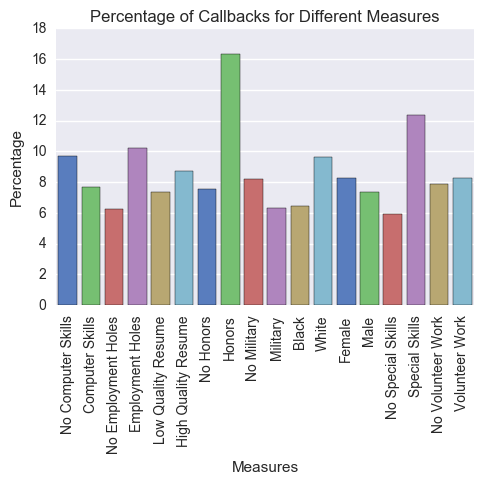

In [40]:
# Plot the percentage of callbacks for the different groups
allgroups_df['prob'] = allgroups_df.prob*100  # convert to percentage 
sns.factorplot(x='labels',y='prob', data=allgroups_df, kind="bar", palette="muted", size=5, aspect=1)
plt.xticks(rotation=90)
plt.title('Percentage of Callbacks for Different Measures')
plt.ylabel('Percentage')
plt.xlabel('Measures')
plt.tight_layout()
plt.savefig('percent_callbacks_all')

** The factors that influence resume callbacks positively in order of most importance are:  honors, special skills, no employment holes, and white sounding names.**

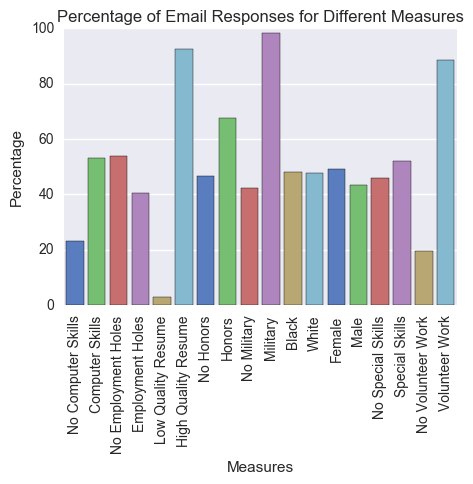

In [41]:
# Plot the percentage of email responses for the different groups
allgroups_df['email_prob'] = allgroups_df.email_prob*100  # convert to percentage 
sns.factorplot(x='labels',y='email_prob', data=allgroups_df, kind="bar", palette="muted", size=5, aspect=1)
plt.xticks(rotation=90)
plt.title('Percentage of Email Responses for Different Measures')
plt.ylabel('Percentage')
plt.xlabel('Measures')
plt.tight_layout()
plt.savefig('percent_emails_all')

**The factors that influence email responses positively in order of most importance are: military service, high quality resume, volunteer work, and honors awards. Given the fact that the email response for low quality resumes was so low, we conclude that the quality of the resume played a large role in resume response.**

In [42]:
# Are there any other measures that are of interest that should be investigated?
data.columns.values

array(['id', 'ad', 'education', 'ofjobs', 'yearsexp', 'honors',
       'volunteer', 'military', 'empholes', 'occupspecific', 'occupbroad',
       'workinschool', 'email', 'computerskills', 'specialskills',
       'firstname', 'sex', 'race', 'h', 'l', 'call', 'city', 'kind',
       'adid', 'fracblack', 'fracwhite', 'lmedhhinc', 'fracdropout',
       'fraccolp', 'linc', 'col', 'expminreq', 'schoolreq', 'eoe',
       'parent_sales', 'parent_emp', 'branch_sales', 'branch_emp', 'fed',
       'fracblack_empzip', 'fracwhite_empzip', 'lmedhhinc_empzip',
       'fracdropout_empzip', 'fraccolp_empzip', 'linc_empzip', 'manager',
       'supervisor', 'secretary', 'offsupport', 'salesrep', 'retailsales',
       'req', 'expreq', 'comreq', 'educreq', 'compreq', 'orgreq', 'manuf',
       'transcom', 'bankreal', 'trade', 'busservice', 'othservice',
       'missind', 'ownership'], dtype=object)

**Let's investigate level of education, number of previous jobs held, and number of years experience as they relate to resume callbacks.**

In [43]:
# create a dataframe for level of education
education_df = create_email_call_df(data,'education')
education_df

,email,no_email,email_total,email_prob,call,nocall,total,prob
education,,,,,,,,
0,22.0,24.0,46.0,0.478261,3.0,43.0,46.0,0.065217
1,9.0,31.0,40.0,0.225000,3.0,37.0,40.0,0.075000
2,97.0,177.0,274.0,0.354015,25.0,249.0,274.0,0.091241
3,588.0,418.0,1006.0,0.584493,84.0,922.0,1006.0,0.083499
4,1618.0,1886.0,3504.0,0.461758,277.0,3227.0,3504.0,0.079053


 It looks like the number of years represent the number of years of college or post high school work

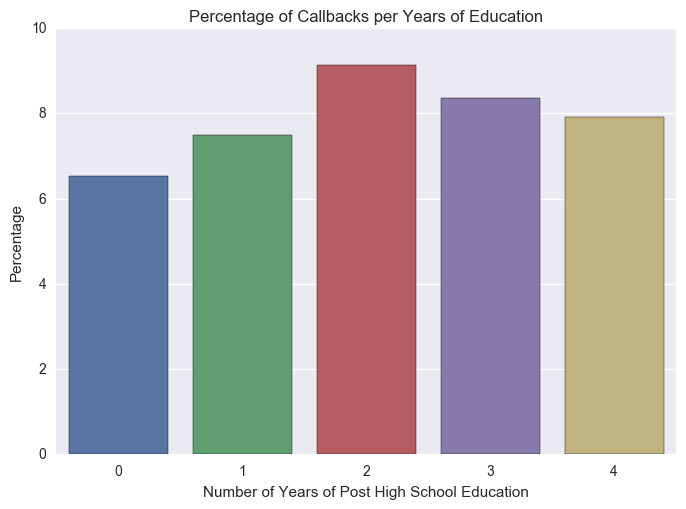

In [44]:
# sort the df, convert 'prob' column to percent, then plot
education_df = education_df.sort_index() # sort by index for the plot
education_df['prob'] = education_df.prob*100
education_df['Years Education'] = education_df.index.values
sns.barplot(x='Years Education', y='prob', data=education_df)
plt.title('Percentage of Callbacks per Years of Education')
plt.xlabel('Number of Years of Post High School Education')
plt.ylabel('Percentage')
plt.savefig('percent_callbacks_educ')

**The number of callbacks was greatest for those candidates that had 2 years post graduate work.  We can conclude that the types of positions the employers were targeting were not positions for college educated candidates.**

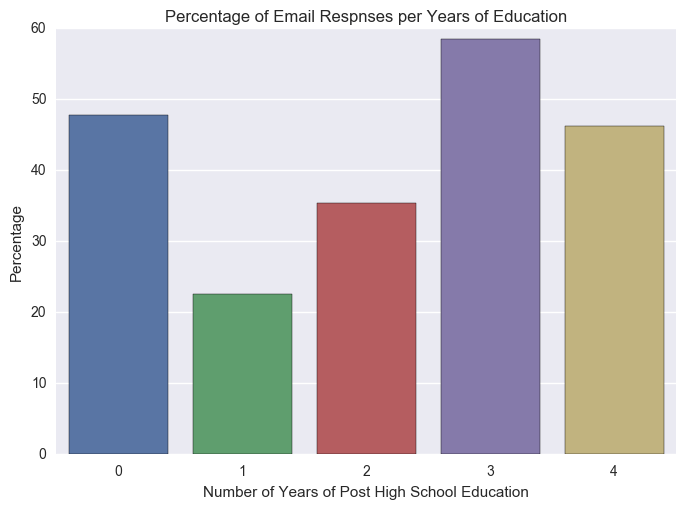

In [45]:
# repeat for email responses

education_df['email_prob'] =education_df.email_prob*100
sns.barplot(x='Years Education', y='email_prob', data=education_df)
plt.title('Percentage of Email Respnses per Years of Education')
plt.xlabel('Number of Years of Post High School Education')
plt.ylabel('Percentage')
plt.savefig('percent_emails_educ')

** The candidates with 3 years of post high school education received the greatest percentage of email responses requesting an interiew.**

In [46]:
# Let's look at the callbacks and email responses related to number of previous jobs held
jobs_df = create_email_call_df(data, 'ofjobs')

In [47]:
jobs_df

,email,no_email,email_total,email_prob,call,nocall,total,prob
ofjobs,,,,,,,,
1,46.0,64.0,110.0,0.418182,15.0,95.0,110.0,0.136364
2,200.0,504.0,704.0,0.284091,64.0,640.0,704.0,0.090909
3,696.0,733.0,1429.0,0.487054,99.0,1330.0,1429.0,0.069279
4,750.0,861.0,1611.0,0.465549,111.0,1500.0,1611.0,0.068901
5,281.0,252.0,533.0,0.527205,65.0,468.0,533.0,0.121951
6,358.0,106.0,464.0,0.771552,36.0,428.0,464.0,0.077586
7,3.0,16.0,19.0,0.157895,2.0,17.0,19.0,0.105263


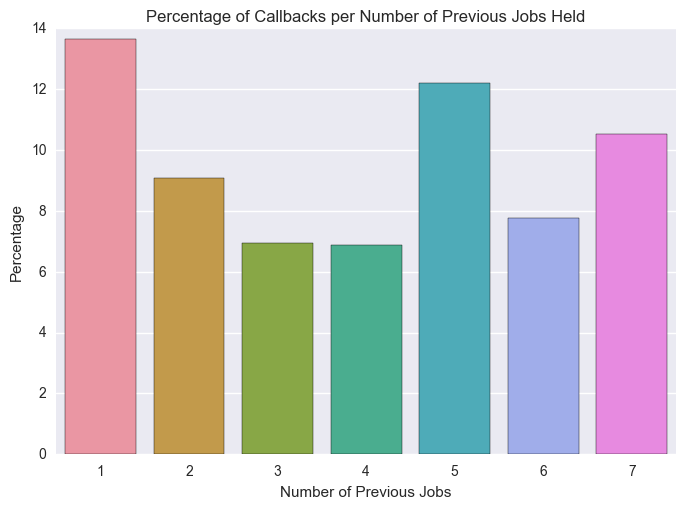

In [48]:
# sort the df, convert 'prob' column to percent, then plot
jobs_df_sorted = jobs_df.sort_index()
jobs_df_sorted['Number of Previous Jobs'] = jobs_df_sorted.index.values
jobs_df_sorted['prob'] = jobs_df_sorted.prob*100
sns.barplot(x='Number of Previous Jobs', y='prob', data=jobs_df_sorted)
plt.ylabel('Percentage')
plt.title('Percentage of Callbacks per Number of Previous Jobs Held')
plt.savefig('percent_callbacks_ofjobs')

**The most callbacks occured for candidates who had held only one previous job and second highest was those who had held 5 previous jobs.  We can conclude that the employers were seeking candidates that are "trainable" or that have a demonstrated record of previous hirings.**

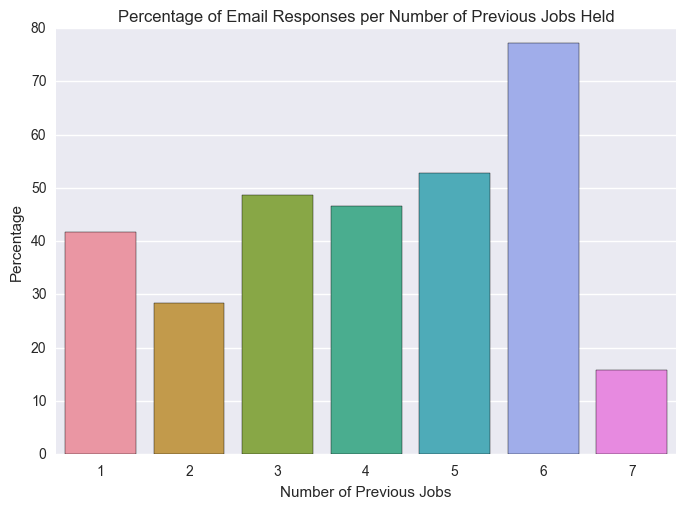

In [49]:
# repeat for email responses
jobs_df_sorted['email_prob'] = jobs_df_sorted.email_prob*100
sns.barplot(x='Number of Previous Jobs', y='email_prob', data=jobs_df_sorted)
plt.ylabel('Percentage')
plt.title('Percentage of Email Responses per Number of Previous Jobs Held')
plt.savefig('percent_emails_ofjobs')

** The candidates with 6 previous jobs received the greatest percentage of email responses.**

In [50]:
# Let's look at the number of years of experience versus callbacks and email responses
yearsexp_df = create_email_call_df(data,'yearsexp')
yearsexp_df

,email,no_email,email_total,email_prob,call,nocall,total,prob
yearsexp,,,,,,,,
1,3.0,42.0,45.0,0.066667,3.0,42.0,45.0,0.066667
2,248.0,104.0,352.0,0.704545,22.0,330.0,352.0,0.062500
3,84.0,110.0,194.0,0.432990,9.0,185.0,194.0,0.046392
4,228.0,309.0,537.0,0.424581,44.0,493.0,537.0,0.081937
5,304.0,203.0,507.0,0.599606,36.0,471.0,507.0,0.071006
6,236.0,581.0,817.0,0.288862,49.0,768.0,817.0,0.059976
7,183.0,358.0,541.0,0.338262,42.0,499.0,541.0,0.077634
8,366.0,212.0,578.0,0.633218,42.0,536.0,578.0,0.072664
9,114.0,45.0,159.0,0.716981,15.0,144.0,159.0,0.094340


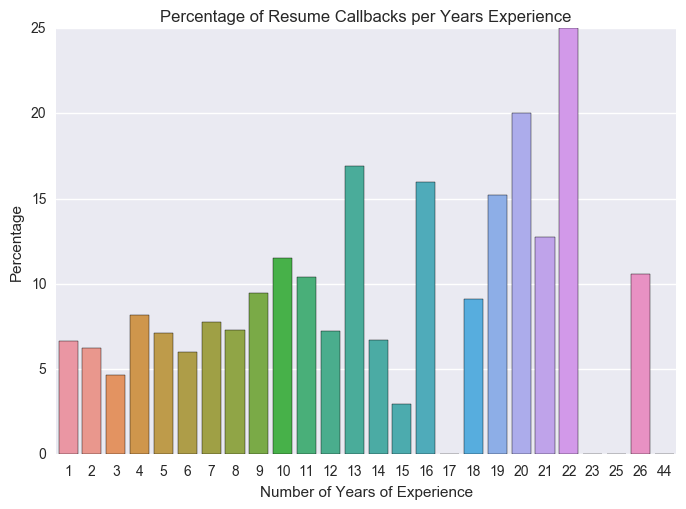

In [51]:
# sort the df, convert 'prob' column to percent, then plot
yearsexp_sorted = yearsexp_df.sort_index()
yearsexp_sorted['Number of Years of Experience'] = yearsexp_sorted.index.values
yearsexp_sorted['prob'] = yearsexp_sorted.prob*100
sns.barplot(x='Number of Years of Experience', y='prob', data=yearsexp_sorted)
plt.ylabel('Percentage')
plt.title('Percentage of Resume Callbacks per Years Experience')
plt.savefig('percent_callbacks_exp')

** In general, as the years of experience increase, the proability of a callback increases.  However, for more than 22 years of experience, the number of callbacks decreases significantly.  This may be an indication of age discrimination, the candidate being over qualified for the position, or the candidate's salary requirement is too high for the position.**

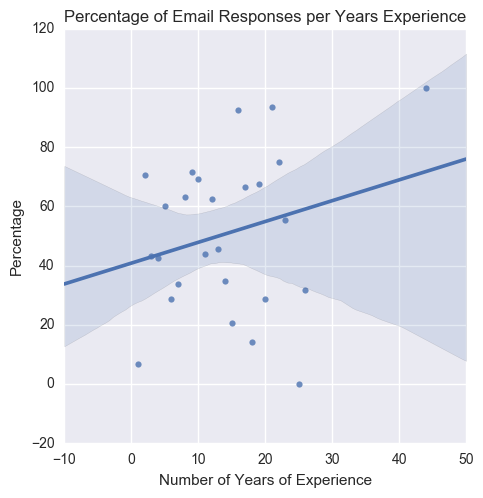

In [52]:
# repeat for email responses
yearsexp_sorted['email_prob'] = yearsexp_sorted.email_prob*100
sns.lmplot(x='Number of Years of Experience', y='email_prob', data=yearsexp_sorted)
plt.ylabel('Percentage')
plt.title('Percentage of Email Responses per Years Experience')
plt.savefig('percent_emails_exp')

** Generally speaking, the percentage of resumes that received email responses is higher for larger numbers of years of experience.**

In [53]:
fracblack_empzip_df = create_email_call_df(data, 'fracblack_empzip')
fracblack_empzip_df = fracblack_empzip_df.sort_index()
fracblack_empzip_df

,email,no_email,email_total,email_prob,call,nocall,total,prob
fracblack_empzip,,,,,,,,
0.000000,35,27,62,0.564516,10.0,52.0,62.0,0.161290
0.000396,10,6,16,0.625000,1.0,15.0,16.0,0.062500
0.000576,2,2,4,0.500000,0.0,4.0,4.0,0.000000
0.000647,0,4,4,0.000000,0.0,4.0,4.0,0.000000
0.000795,0,2,2,0.000000,0.0,2.0,2.0,0.000000
0.000904,4,4,8,0.500000,0.0,8.0,8.0,0.000000
0.000981,2,0,2,1.000000,0.0,2.0,2.0,0.000000
0.001075,2,2,4,0.500000,0.0,4.0,4.0,0.000000
0.001092,2,2,4,0.500000,0.0,4.0,4.0,0.000000


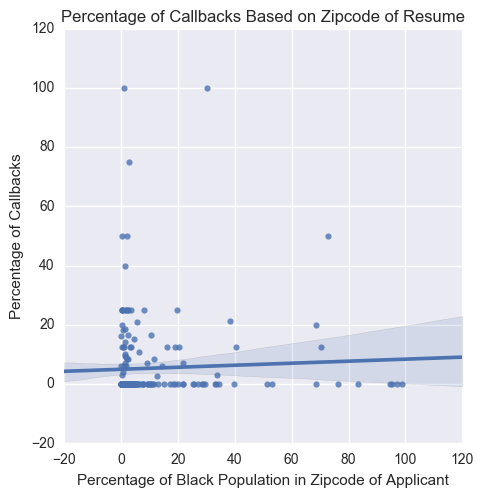

In [54]:
fracblack_empzip_df['prob']=fracblack_empzip_df.prob * 100
fracblack_empzip_df['percentzipblack'] = fracblack_empzip_df.index.values*100
sns.lmplot(x='percentzipblack', y = 'prob', data= fracblack_empzip_df)
plt.title('Percentage of Callbacks Based on Zipcode of Resume')
plt.xlabel('Percentage of Black Population in Zipcode of Applicant')
plt.ylabel('Percentage of Callbacks')
plt.savefig('percent_callbacks_blackzip')

** There does not appear to be an obvious correlation between a callback and the percentage of black population in the zipcode of the candidate. There is a cluster of data in the zipcodes with less than 20% black population.**

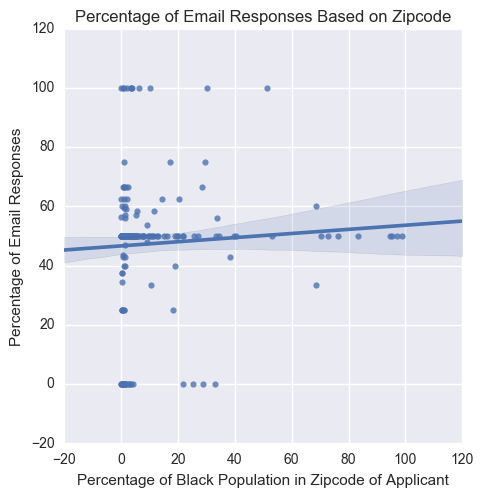

In [55]:
fracblack_empzip_df['email_prob']=fracblack_empzip_df.email_prob * 100
sns.lmplot(x='percentzipblack', y = 'email_prob', data= fracblack_empzip_df)
plt.title('Percentage of Email Responses Based on Zipcode')
plt.xlabel('Percentage of Black Population in Zipcode of Applicant')
plt.ylabel('Percentage of Email Responses')
plt.savefig('percent_emails_blackzip')

** The data is somewhat spread evenly for zipcodes with black populations less than 40%. However, there is no clear correlation. And there is still approximately 50% email response for zipcodes up to 100% black population.  Considering the fact that the callback rate in general is 48%, this indicates that the zipcode of the applicant did not have an influence.**

## Conclusion

## Does Race Influence Resume Callbacks?

## Questions
- Is there a difference in the probability of a resume callback for a person with a black sounding name versus a person with a white sounding name?
- If there is a difference, is the difference statistically significant?
- If it is statistically significant, can we say that race bias influences employment opportunities for persons with black sounding names?
- Are there any other factors that influence resume callbacks and how do those factors compare to race bias?

## Background
- From 2000 to 2002, approximately 5000 resumes were sent in response to 1300 newspaper ads for positions in sales, administrative work, and clerical jobs in Chicago and Boston.
- Resumes were randomly assigned "black" or "white" sounding names.
- In addition, the resumes varied by quality with high quality resumes including additional factors such as volunteer work, honors awards, military service, and computer skills.
- Four resumes were sent to each employer: two high quality and two low quality.
- A callback or email soliciting a request for an interview was recorded.

# Data Analysis Summary
- The percentage of resumes that received a call back for the "white" group was 9.6% and the percentage for the "black" group was 6.4%.  The difference in callbacks between the groups was 3.2%.
- Proportion hypothesis testing was conducted on difference in callbacks based on race. The difference was found to be statistically significant. 
- Proportion hypothesis testing was repeated for difference in email responses based on race. There was no difference in email responses based on race. 
- Proportion hypothesis testing was repeated for the following variables: computer skills, employment holes, quality of resume, gender, military service, volunteer work, honors awards, and special skills.  The difference in callbacks and email responses was plotted for all the variables.  Many factors were found to affect the callback and email response percentages and for many variables there was a much higher percentage difference than that found for race difference.
- Finally, other factors such as education level, number of jobs previously held, number of years of experience, and the applicant's zipcode were investigated.

# Data Analysis Results

<tr>
    <td> <img src="percent_callbacks_race.png" alt="Drawing" style="width: 400px;"/> </td>
    <td> <img src="percent_emails_race.png" alt="Drawing" style="width: 400px;"/> </td>
    </tr>

** There is a 3.2% difference in callbacks between the "black" and "white" groups. There is no difference in email responses between the "black" and "white" groups.**


<tr>
    <td> <img src="percent_callbacks_all.png" alt="Drawing" style="height: 400px"/> </td>
    <td> <img src="percent_emails_all.png" alt="Drawing" style="height: 400px;"/> </td>
    </tr>

**Note that a high percentage of the callbacks were for candidates with no computer skills and with employment holes.  This indicates that the callbacks were required due to the candidate's lack of access to email and the internet.  The fact that there was a high percentage with honors and special skills indicates that although there were weaknesses in the resume, these factors prompted a callback. There was a higher percentage of callbacks for the "white" group in comparison to the "black" group and there was a higher percentage of callbacks for the "female" group in comparison to the "male" group.**

** Looking at the difference in callback and email responses for each measure, the quality of the resume affected the email response the most followed by volunteer work. There is an almost 100% callback for having served in the military.**

<tr>
    <td> <img src="percent_callbacks_blackzip.png" alt="Drawing" width="400px"/> </td>
    <td> <img src="percent_emails_blackzip.png" alt="Drawing" style="width: 400px;"/> </td>
    </tr>

**There is no clear correlation (the lines are flat) between zipcode and callbacks or email responses.  Although, there are more data points on the left sides of the graphs for zipcodes with a smaller fraction of "black" population, there may be more neighborhoods with a lower fraction of "blacks".  Therefore, we can conclude that the zipcode of the applicant did not influence the email or callback response.**

# Conclusions
- There is no race bias in email responses to resumes.  
- Although there was some statistical evidence of bias in callbacks, the effect of race is smaller when compared with other factors such as special skills and honors awards.
- The email response percentage was 48% while the callback percentage was 16% indicating that the data associated with the email responses is more valuable. The callbacks could have been influenced by the candidates' lack of access to email and the internet or by the quality of the resume(no email address listed).
- The quality of the resume had the greatest effect in email responses.  Therefore, the introduction of two qualities of resumes into the study unduly affected the results of the study. 
- The variables that received the highest percentages of email responses were military service, high quality resume, volunteer work, and honors awards. Gender played a higher role in resume email responses than race with race playing no role at all.
- The candidate having a zipcode with a high percentage of black residents did not affect the email response percentage.

# Recommendations
- Conduct a study where all the variables are kept constant except for the one variable of race.  To do this, create two high quality resumes targeting the skills required of the jobs, assign a "black" sounding name to one and a "white" sounding name to another, then submit both resumes to each job advertised.
- Since the ultimate test of bias is in actually obtaining employment, create an experiment with real people and then measure job offers extended.
- If the email responses are computer generated based on skills and talents listed on the resume, then human bias would be removed from the equation and equal job opportunity for all would be realizable.